In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os
from FACS_Sampling.utils import create_adata

sc.set_figure_params(figsize=(8,8), fontsize=15, )

In [2]:

# Get the file path from the environment variable
file_path_env = os.getenv('MY_FACS_DATA_PATH')
input_file1 = os.path.join(file_path_env,'sara_data', 'reps',f"random_adata_2_0__0.h5ad")
input_file2 = os.path.join(file_path_env,'sara_data', 'reps',f"fsbs_adata_2_0__0.h5ad")

adata_random = sc.read_h5ad(input_file1)
adata_fsbs =  sc.read_h5ad(input_file2)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/fast/AG_Haghverdi/Ehsan_Karimiara/facs_sampling/sara_data/reps/random_adata_2_0__0.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
data.columns

Index(['cd33_aligned', 'hla_dr_aligned', 'cd19_cd3_aligned', 'cd11b_aligned',
       'cd66b_aligned', 'cd16_aligned', 'cd163_aligned', 'cd14_aligned',
       'cd2_aligned', 'siglec8_aligned', 'cd13_aligned', 'cd45_aligned',
       'cd141_aligned', 'cd15_aligned', 'cd123_aligned', 'cd11c_aligned',
       'cd117_aligned', 'cd45ra_aligned', 'cd34_aligned', 'itgb7_aligned',
       'cd88_cd89_aligned', 'fcer1a_aligned', 'unique_id', 'sex', 'age',
       'subtype', 'type', 'blastcount', 'survival_sorter', 'run', 'sample_id',
       'alignment_mc_aligned', 'flowsom_cluster', 'flowsom_metacluster',
       'population'],
      dtype='object')

In [4]:
data.head()

,cd33_aligned,hla_dr_aligned,cd19_cd3_aligned,cd11b_aligned,cd66b_aligned,cd16_aligned,cd163_aligned,cd14_aligned,cd2_aligned,siglec8_aligned,...,subtype,type,blastcount,survival_sorter,run,sample_id,alignment_mc_aligned,flowsom_cluster,flowsom_metacluster,population
0,516.321106,521.266785,376.891998,345.141083,266.605988,281.500000,605.299988,494.700012,245.566605,412.100006,...,"nk,_npm1_wt;_flt3_itd_(<0,5)",pb,90,"69,2",9,20021,10,185,28,late_promyelocyte_like
1,366.496277,702.265015,494.233490,401.720001,333.208466,390.930359,681.159668,501.387512,618.622925,355.858368,...,"complex,_del5",bm,30,"36,3",3,115,14,16,1,pdc_progenitor_like
2,236.373978,331.454926,63.362976,701.075012,723.460571,723.144714,794.627991,717.584900,126.181435,482.438690,...,"nk,_npm1+_flt3_itd_(<0,5)",pb,no_punction,"56,2",6,359,3,80,17,neutrophil_like
3,483.071594,342.806610,236.699997,220.152588,367.799988,354.808075,743.941956,531.299988,408.799988,377.799988,...,"nk,_npm1+_flt3_itd_(<0,5)",pb,no_punction,"56,2",6,359,12,142,24,(progenitor)_erythroid_like
4,305.014801,449.230835,356.223236,499.265442,200.997070,252.656006,632.299988,461.299988,215.479202,448.100006,...,trisomy_8,bm,100,"65,6",3,183,13,71,2,hspc_like


Creating adata from the dataframe will help us to process and manage the data easier.

In [5]:
index = data.index
labels = data['population']
label_key = 'population'

obs_features = ['old_index', 'unique_id', 'sex', 'age', 'subtype', 'type', 'blastcount',
                'survival_sorter', 'run','sample_id','alignment_mc_aligned',
                'flowsom_cluster', 'flowsom_metacluster','population']
adata = create_adata(data, obs_features=obs_features)

/home/ekarimi/miniconda3/envs/facs_sampling/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
print(adata.X.max())
x = np.arcsinh(adata.X/500)
adata.X = x

6788.94482421875


In [26]:
adata

AnnData object with n_obs × n_vars = 2000000 × 22
    obs: 'unique_id', 'sex', 'age', 'subtype', 'type', 'blastcount', 'survival_sorter', 'run', 'sample_id', 'alignment_mc_aligned', 'flowsom_cluster', 'flowsom_metacluster', 'population', 'old_index'

In [27]:
from FACS_Sampling.methods.methods import bin_sample, sample_random, dist_sampling
from FACS_Sampling.utils import set_reference_colors
from FACS_Sampling.plotting.plotting import change_cmap

In [28]:
cluster_key = label_key
ref_adata = adata

In [37]:
output_adata_ref = os.path.join(file_path_env,'sara_data', 'adata_ref_sara_2M.h5ad')
adata.write(output_adata_ref)

### Draw samples

In [29]:
def sample_random(adata, s_size=1000, seed=12345):
    np.random.seed(seed)
    rand_index1 = np.random.choice(adata.obs.index, s_size, replace=False)
    rand_index1 = np.array(list(map(int, rand_index1)))

    return rand_index1

In [30]:
def bin_sample(adata, s_size=20, n_bins=10, seed=12345):
    np.random.seed(seed)
    total_indices = np.array([])
    for gene in adata.var_names.values:
        indices = np.array([])
        mini = adata[:, [gene]]
        std = np.std(np.array(mini.X))
        rng = 12*std
        mean = np.mean(np.array(mini.X))
        
        measures = [-np.inf]
        if n_bins > 2:
            step = rng/(n_bins-2)
        else:
            step = 0
            
        for i in range(n_bins//2 -1):
            measures.append(mean - rng/2 + i*step)
        
        measures.append(mean)
        
        for i in range(n_bins//2 -1):
            measures.append(mean + (i+1)*step)

        measures.append(np.inf)
            
#         measures = [-np.inf]
#         var = (n_bins - 2) / 2
#         for i in range(n_bins - 1):
#             measures.append(mean - var * std)
#             var -= 1
#         measures.append(np.inf)

        for item in range(len(measures) - 1):
            measure1, measure2 = measures[item], measures[item + 1]
            local_indices = adata[np.array(mini.X > measure1) & np.array(mini.X < measure2)].obs.index.to_numpy()
            if len(local_indices) > s_size:
                indices = np.append(indices, np.random.choice(local_indices, s_size, replace=False))
                # if item==0 or item==len(measures)-2:
                #     indices = np.append(indices,local_indices)
                # else:
                #     indices = np.append(indices, np.random.choice(local_indices, s_size, replace=False))
            elif len(local_indices) > 0:
                indices = np.append(indices, local_indices)

        total_indices = np.append(total_indices, indices)
        total_indices = np.array(list(map(int, total_indices)))


    return np.unique(total_indices), total_indices


In [31]:
from scipy.spatial.distance import pdist, squareform

def dist_sampling(adata, sample_per_matrix=4, rng=1000, seed=12345):
    adata.obs = adata.obs.reset_index()
    np.random.seed(seed)
    all_indices = adata.obs.index.to_numpy().astype(int)
    np.random.shuffle(all_indices)

    start_i = 0
    if all_indices.shape[0] % rng != 0:
        end_of_range = int(all_indices.shape[0] / rng + 1)
    else:
        end_of_range = int(all_indices.shape[0] / rng)

    output = []
    for i in range(end_of_range):
        samples = all_indices[start_i:start_i + rng]
        start_i += rng

        x = adata.X[samples,]
        # x = stats.zscore(x, axis=1)
        dists = squareform(pdist(x, metric='euclidean'))
        th = np.max(dists)
        mask1 = dists > th
        while (mask1.sum(axis=1) > 0).sum() < 2 * sample_per_matrix:
            th = th / 2
            mask1 = dists > th

        mask = mask1

        fin_scores = np.multiply(dists, mask).sum(axis=0)
        t = samples[np.argsort(fin_scores)[0:sample_per_matrix]]
        output.extend(t)

    output = adata.obs.loc[output]['index'].values
    adata.obs.index = adata.obs['index']
    del adata.obs['index']
    return np.array(output)

In [32]:
fsbs_samples, _ = bin_sample(ref_adata, n_bins=40, s_size=250)
print(f"number of samples drawn from the reference data is : {fsbs_samples.size}")
random_samples = sample_random(ref_adata, s_size=fsbs_samples.size)


number of samples drawn from the reference data is : 121819


In [33]:
# dist_samples = dist_sampling(ref_adata, sample_per_matrix=30, rng=4200, seed= 1356)
# dist_samples.shape

### Plots

In [34]:
sc.set_figure_params(dpi=300, color_map = 'viridis_r', figsize=(8,8), fontsize=15,)
sc.settings.verbosity = 1
sc.logging.print_header()


scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.4 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.11.3 pynndescent==0.5.11


Creating adata with the subsamples data

In [35]:
adata_random = ref_adata[random_samples]
adata_fsbs = ref_adata[fsbs_samples]

In [36]:
cell_type_order = ref_adata.obs[label_key].value_counts().keys().values

# Get value counts for random_samples and fsbs_samples
random_samples_counts = ref_adata[random_samples].obs[label_key].value_counts()
fsbs_samples_counts = ref_adata[fsbs_samples].obs[label_key].value_counts()

# Create a DataFrame that combines the value counts
combined_counts = pd.DataFrame({
    'cell_types': random_samples_counts.index,
    'random_samples': random_samples_counts.values,
    'fsbs_samples': fsbs_samples_counts.reindex(random_samples_counts.index).values
})

print(combined_counts)

                           cell_types  random_samples  fsbs_samples
0                           hspc_like           27719         22049
1                 classical_monocytes           25315         21155
2              late_promyelocyte_like           20376         14033
3         (progenitor)_erythroid_like           14364         11795
4                          myelocytes            6386          7884
5   activated_classical_monocyte_like            6165          5227
6             early_promyelocyte_like            4002          5018
7          intermediate_monocyte_like            3638          5108
8                    cd117+_hscp_like            3371          3085
9                 pdc_progenitor_like            2977          6955
10                    neutrophil_like            1732          9161
11        granulocyte_progenitor_like            1578          2457
12        non_classical_monocyte_like            1485          1781
13        conventional_dendritic_like           

### Bootstraping

In [34]:
ref_adata[fsbs_samples].write('bootstrap_adata/test.h5ad')

In [35]:
def bootstrap(ref_adata, label_key='labels', rep=5, seed=12345):
    np.random.seed(seed)

    groupped_df = pd.DataFrame(data=None, columns=["count", label_key, "method"])
    for i in range(rep):
        new_seed = np.random.randint(100000)

        ps, _ = bin_sample(ref_adata, n_bins=40, s_size=250, seed=new_seed)
        rs = sample_random(ref_adata, s_size=ps.size, seed=new_seed)
        # dist_s = dist_sampling(ref_adata, sample_per_matrix=30, rng=1000, seed=new_seed)
        
        def automation(samples, method_type='Random'):
            
            ref_adata[samples].write(f"bootstrap_adata/{method_type}_adata_{rep}__{i}.h5ad")
            a = ref_adata[samples].obs[label_key].value_counts().to_list()
            b = list(ref_adata[samples].obs[label_key].value_counts().keys())
            c = [method_type for _ in a]
            g_df = pd.DataFrame({"count": a, label_key: b, "method": c})
            return g_df
        
        
        g_df1 = automation(rs, method_type='Random')
        g_df2 = automation(ps, method_type='FSBS')
        
        groupped_df = pd.concat([groupped_df, g_df1, g_df2])

    return groupped_df

In [36]:
df_bootstrap = bootstrap(ref_adata, label_key=label_key, rep=5)

In [212]:
df_random = df_bootstrap[df_bootstrap['method'].isin(['Random'])]
df_fsbs = df_bootstrap[df_bootstrap['method'].isin(['FSBS'])]
# df_dist = df_bootstrap[df_bootstrap['method'].isin(['Dist'])]

In [213]:
import seaborn as sns

sns.set(font_scale=1.5)

In [214]:
df_bootstrap

,count,population,method
0,27915,hspc_like,Random
1,25494,classical_monocytes,Random
2,20250,late_promyelocyte_like,Random
3,14134,(progenitor)_erythroid_like,Random
4,6293,myelocytes,Random
...,...,...,...
11,2551,conventional_dendritic_like,FSBS
12,2534,granulocyte_progenitor_like,FSBS
13,1902,eosinophil_like,FSBS
14,1741,non_classical_monocyte_like,FSBS


/home/ekarimi/miniconda3/envs/facs_sampling/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ekarimi/miniconda3/envs/facs_sampling/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ekarimi/miniconda3/envs/facs_sampling/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


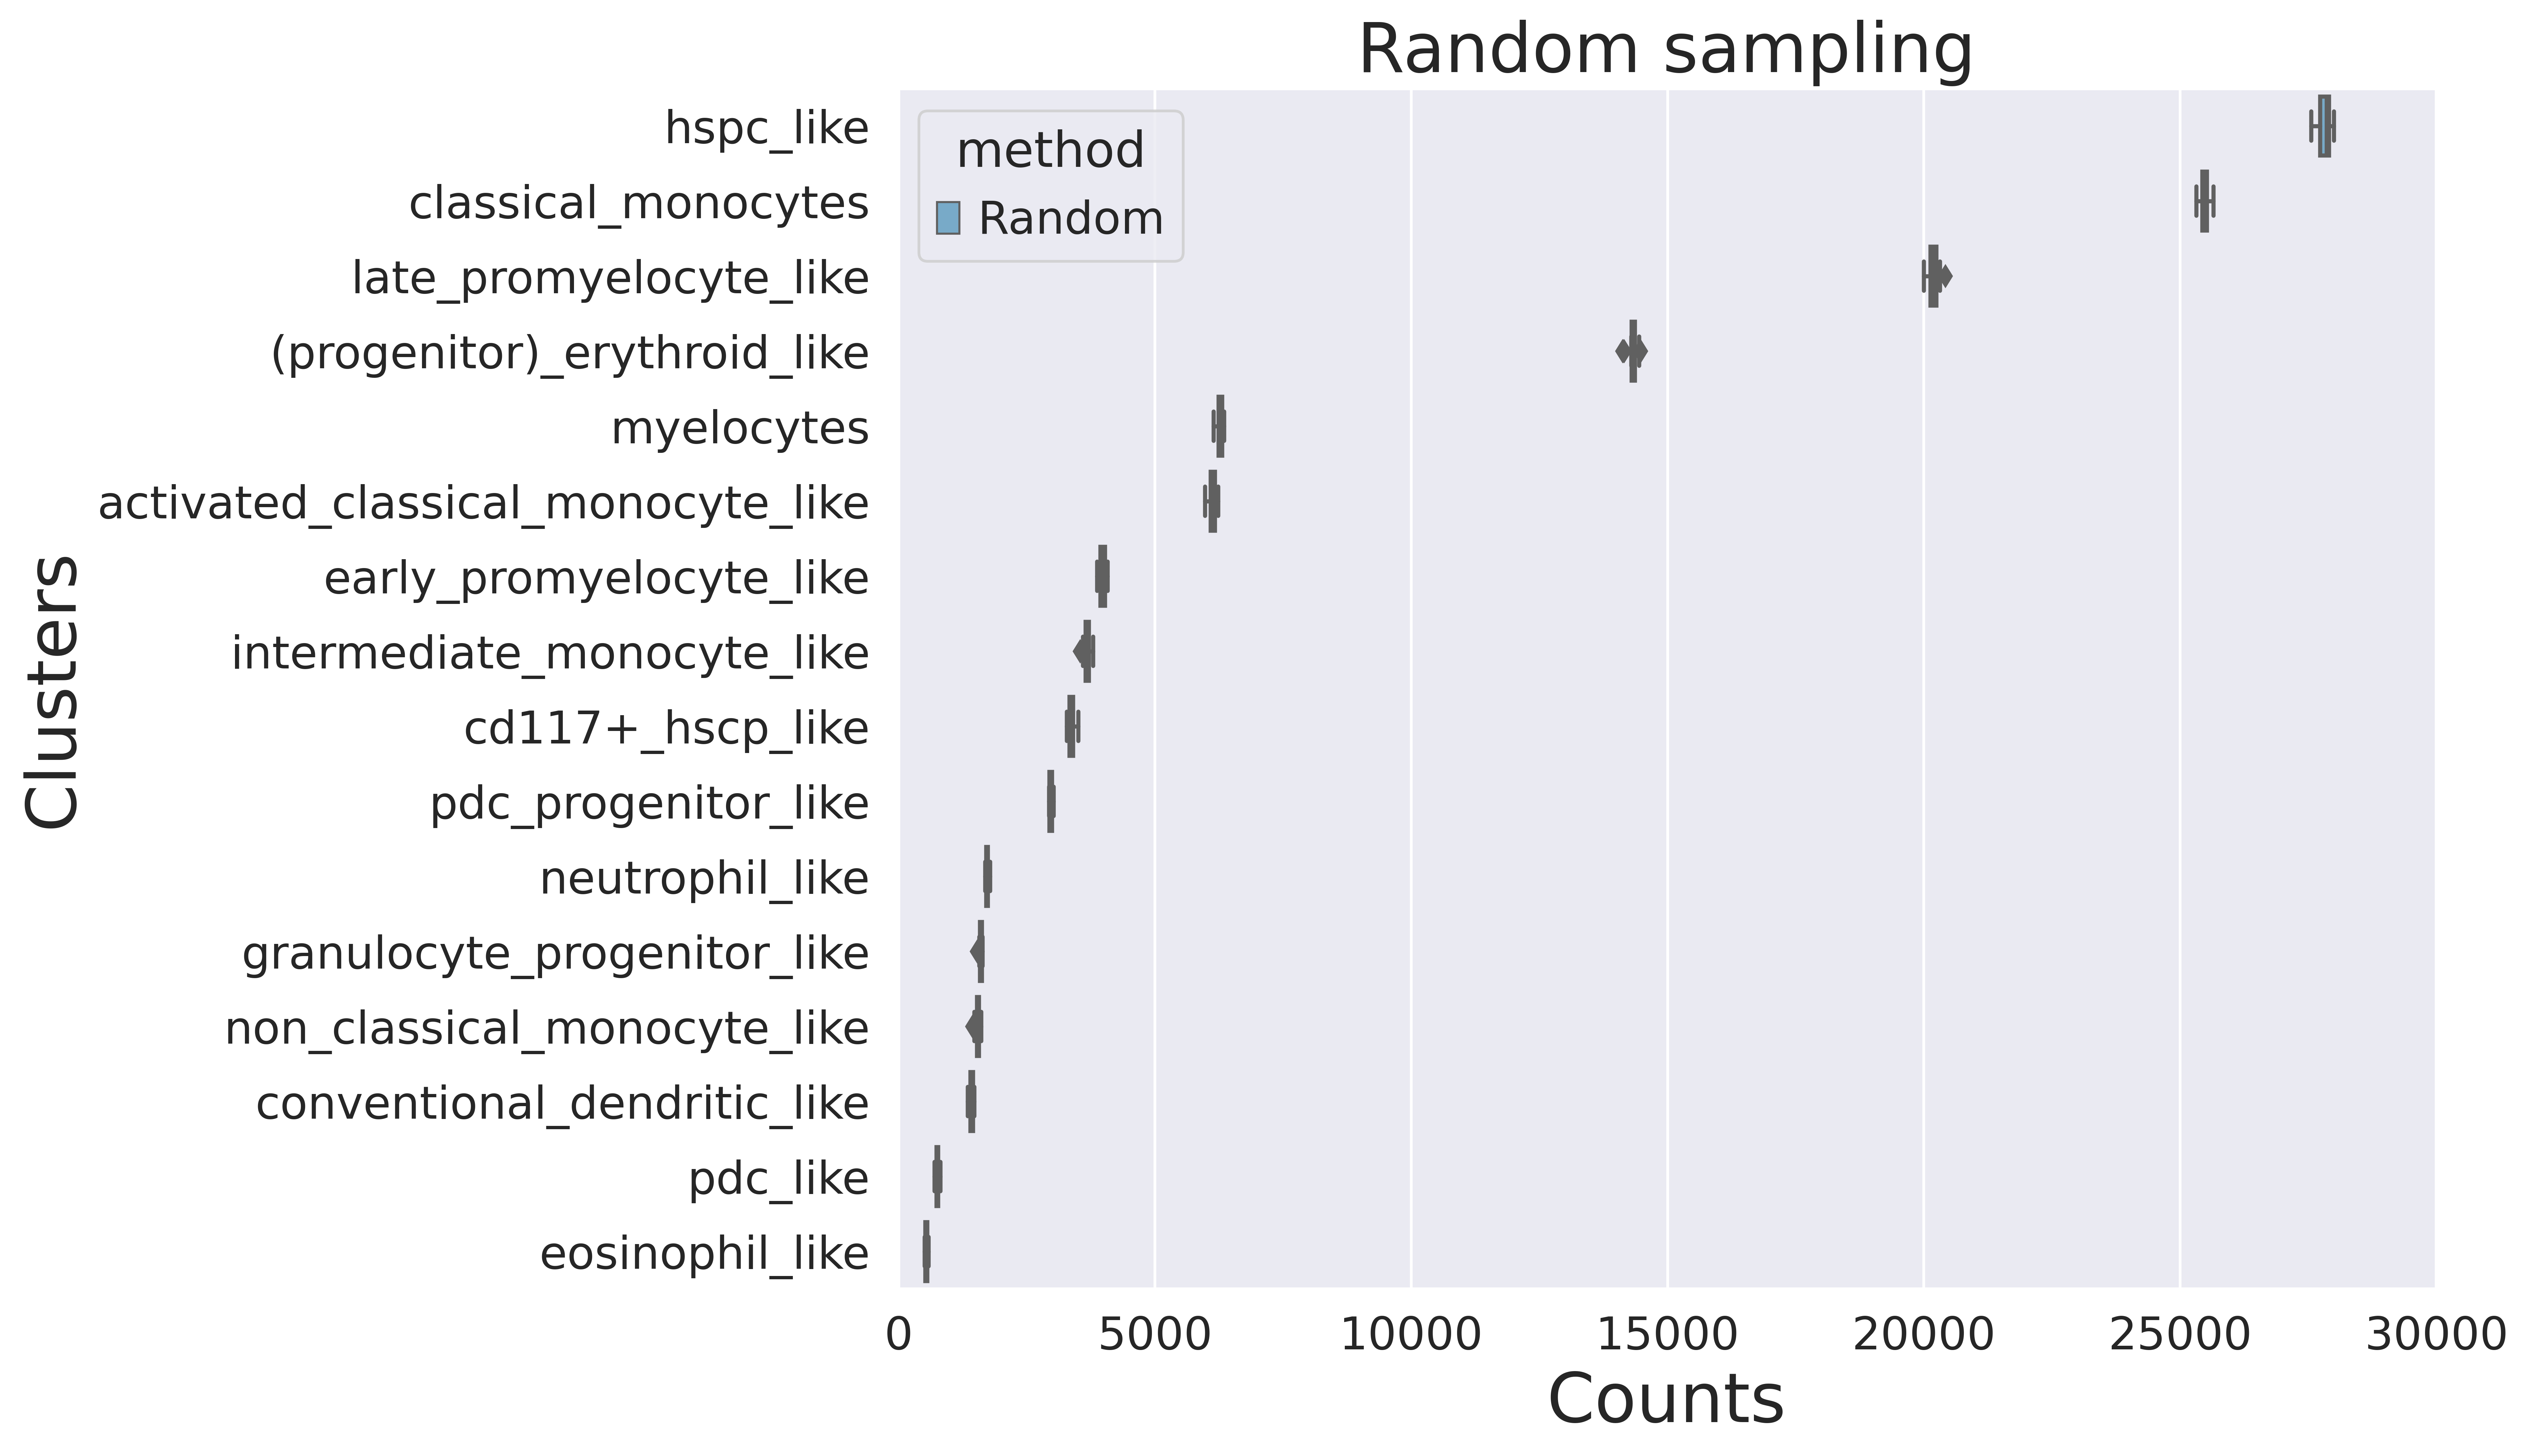

In [216]:
plt.figure(figsize=(10, 8))
g = sns.boxplot(y=label_key, x="count", hue='method',data=df_random,
                orient='h', order= cell_type_order, palette="Blues")
plt.xlim(-50, 30000)
# plt.xticks(rotation=90)
plt.ylabel("Clusters", size = 25)
plt.xlabel("Counts", size = 25)
plt.title("Random sampling", size= 25)
plt.savefig("Random_new.png", dpi=200, bbox_inches='tight', pad_inches = 0.5)

/home/ekarimi/miniconda3/envs/facs_sampling/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ekarimi/miniconda3/envs/facs_sampling/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ekarimi/miniconda3/envs/facs_sampling/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


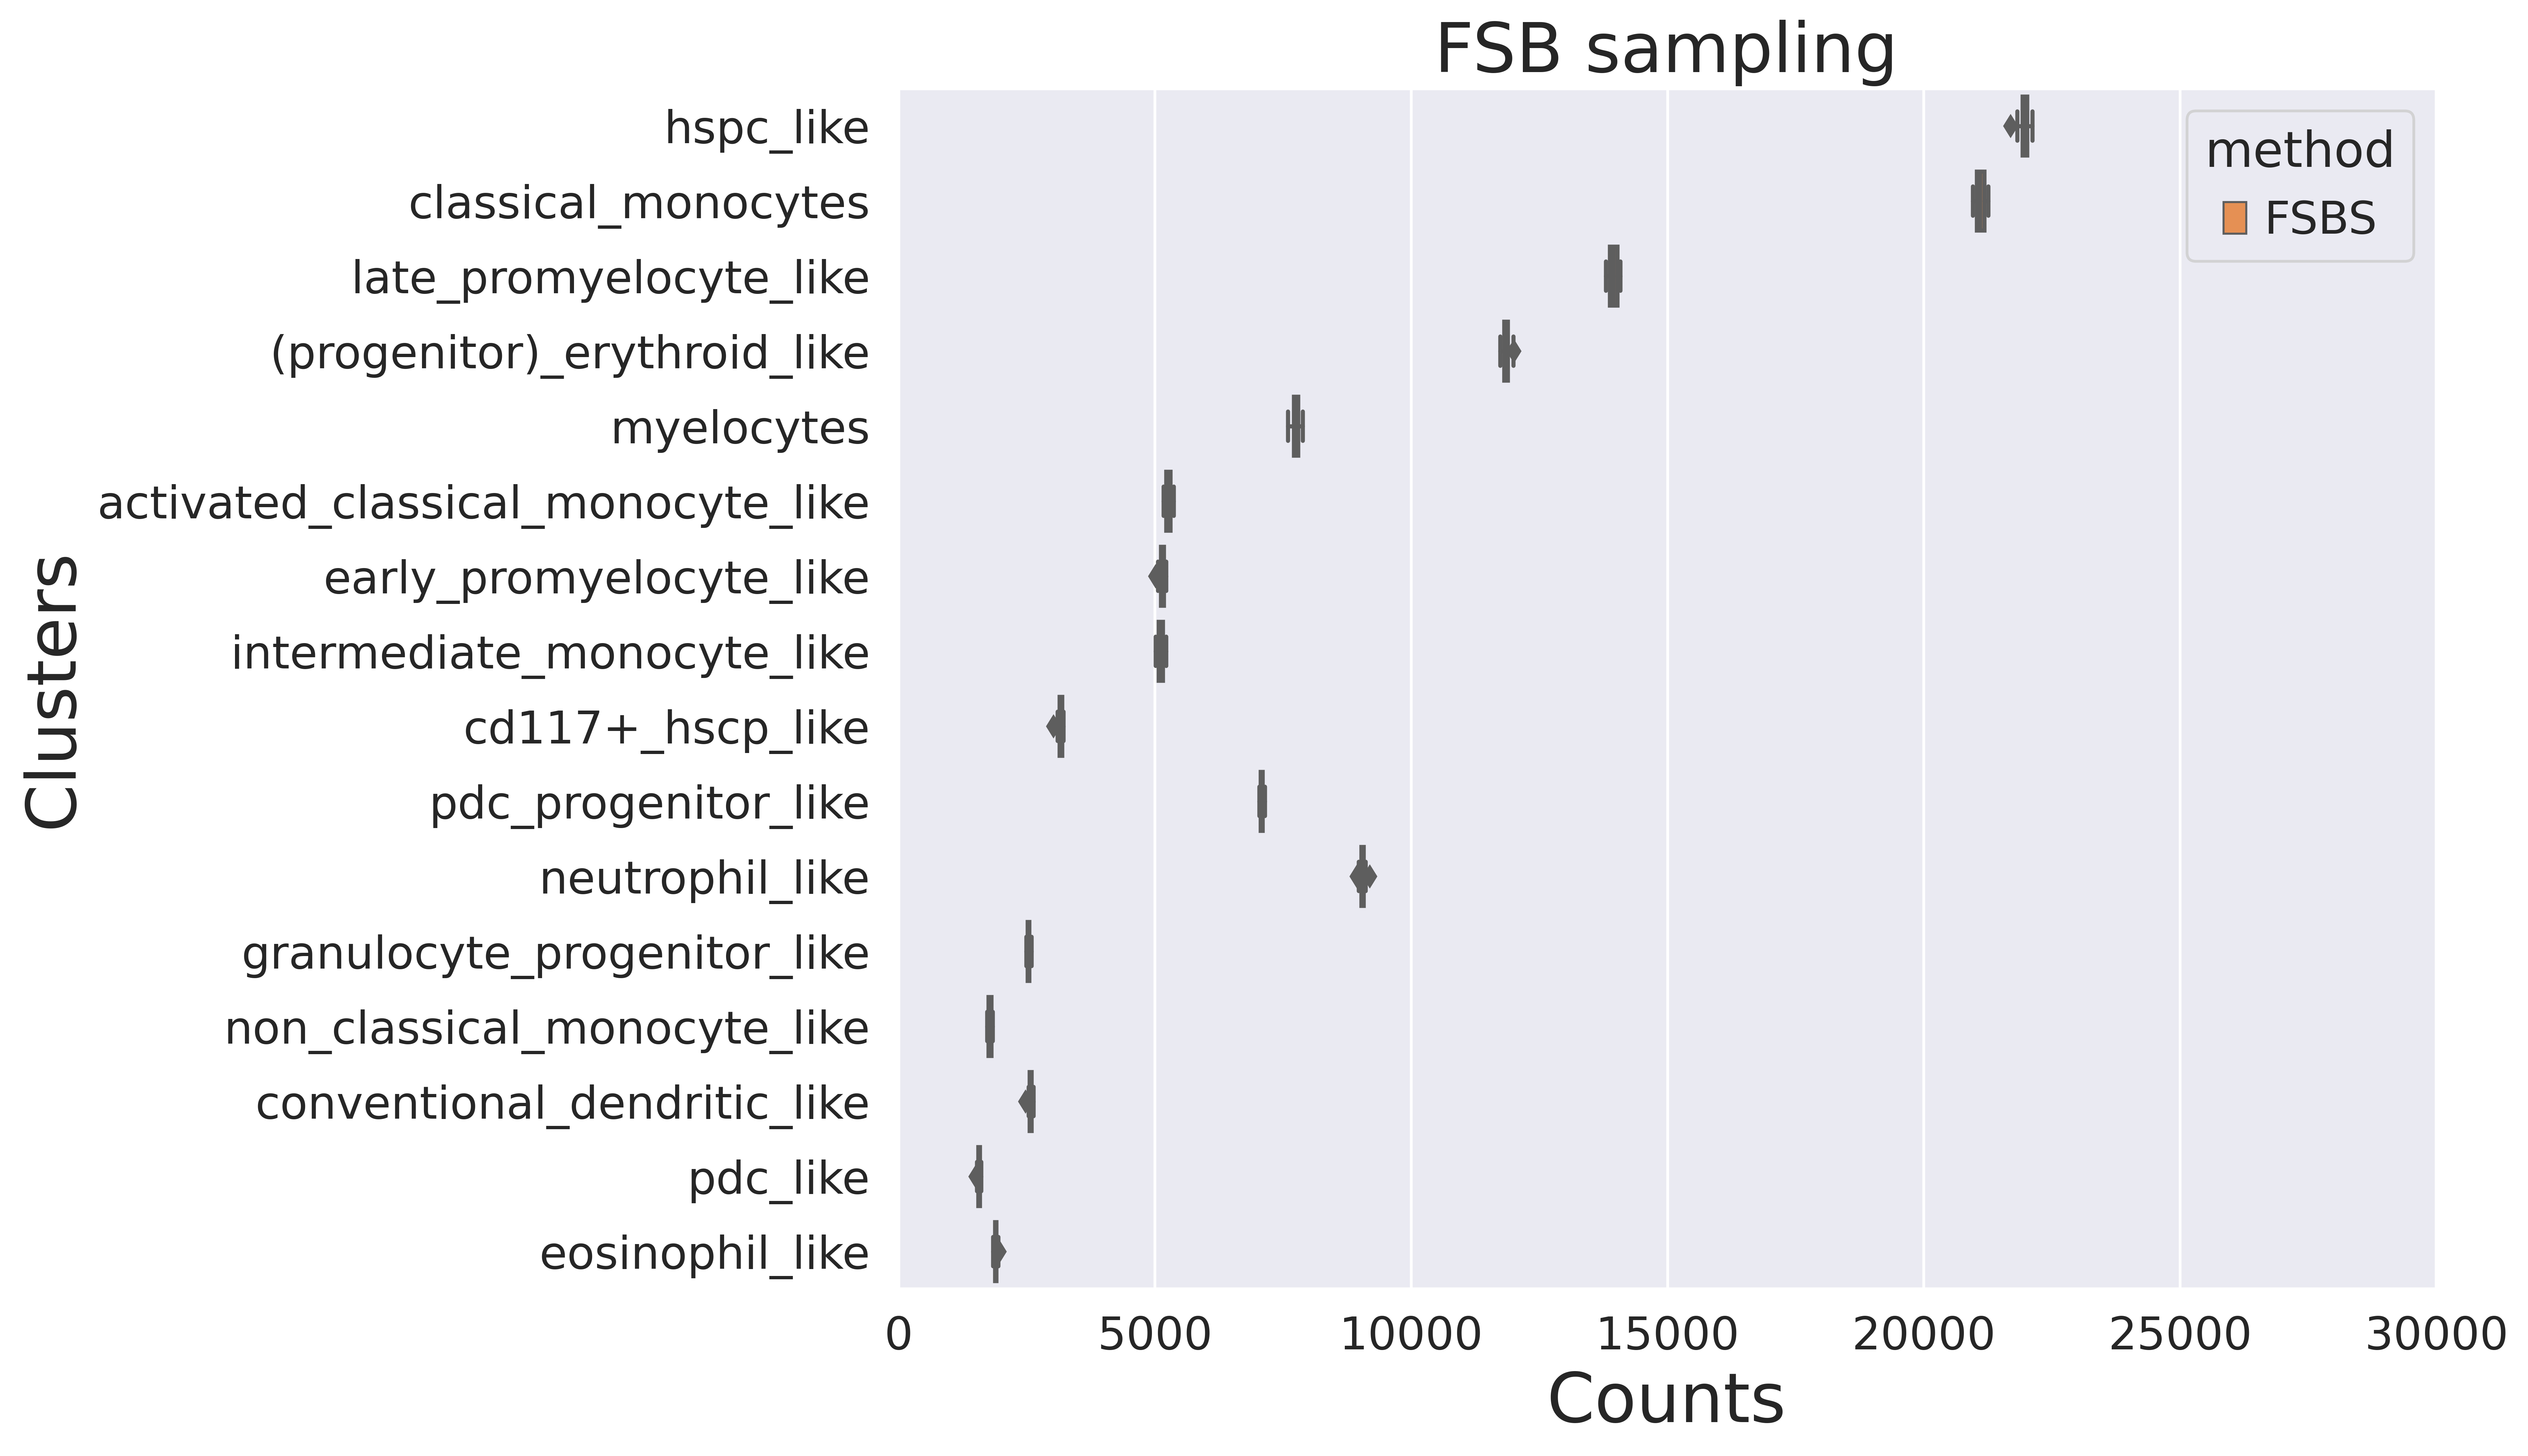

In [217]:
plt.figure(figsize=(10, 8))
g = sns.boxplot(y=label_key, x="count", hue='method',data=df_fsbs,
                orient='h', order= cell_type_order, palette='Oranges')
plt.xlim(-50, 30000)
# plt.xticks(rotation=90)
plt.ylabel("Clusters", size = 25)
plt.xlabel("Counts", size = 25)
plt.title("FSB sampling",  size= 25)
plt.savefig("Fixed_size_bin_sampling_new.png", dpi=200, bbox_inches='tight', pad_inches = 0.5)

In [218]:
adata.obs[label_key].value_counts()

population
hspc_like                            457432
classical_monocytes                  418286
late_promyelocyte_like               331978
(progenitor)_erythroid_like          235059
myelocytes                           102999
activated_classical_monocyte_like    100591
early_promyelocyte_like               65672
intermediate_monocyte_like            60130
cd117+_hscp_like                      55318
pdc_progenitor_like                   48831
neutrophil_like                       28277
granulocyte_progenitor_like           26223
non_classical_monocyte_like           25084
conventional_dendritic_like           23099
pdc_like                              12272
eosinophil_like                        8749
Name: count, dtype: int64

In [219]:
# plt.figure(figsize=(10, 8))
# g = sns.boxplot(y=label_key, x="count", hue='method',data=df_dist,
#                 orient='h', order= cell_type_order, palette="Greens")
# plt.xlim(-50, 3000)
# # plt.xticks(rotation=90)
# plt.ylabel("Clusters", size = 25)
# plt.xlabel("Counts", size = 25)
# plt.title("Dist sampling",  size= 25)
# plt.savefig("Dist_sampling_new.png", dpi=200, bbox_inches='tight', pad_inches = 0.5)

### Check the MNN

In [220]:
from FACS_Sampling.methods.analysis import get_knn_classification_report

In [226]:
!pwd

/fast/home/e/ekarimi/FACS_Sampling/notebooks/Sarah


In [ ]:
knn1 = get_knn_classification_report(random_samples, ref_adata, label_key)[1]
print(knn1)

In [ ]:
knn2 = get_knn_classification_report(fsbs_samples, ref_adata, label_key)[1]
print(knn2)

In [ ]:
print("hello")

In [4]:
!pwd

/fast/home/e/ekarimi/FACS_Sampling/notebooks/Sarah


In [ ]:
knn1.to_csv('knn_clf_random.csv')

In [ ]:
knn2.to_csv('knn_clf_fsbs.csv')

In [ ]:
random_clf_report = {'(progenitor)_erythroid_like': {'precision': 0.9154801408593777, 'recall': 0.9269361972024136, 'f1-score': 0.9211725524267049, 'support': 233344.0}, 'activated_classical_monocyte_like': {'precision': 0.8966434097678975, 'recall': 0.898421537598654, 'f1-score': 0.8975315930080145, 'support': 99844.0}, 'cd117+_hscp_like': {'precision': 0.7976701410177806, 'recall': 0.5683083979469259, 'f1-score': 0.6637331802818699, 'support': 54942.0}, 'classical_monocytes': {'precision': 0.9275491337396425, 'recall': 0.9785341373198736, 'f1-score': 0.9523597475373643, 'support': 415264.0}, 'conventional_dendritic_like': {'precision': 0.8723941543090479, 'recall': 0.707864678699102, 'f1-score': 0.7815643802647413, 'support': 22938.0}, 'early_promyelocyte_like': {'precision': 0.8457626578242571, 'recall': 0.8139210211408058, 'f1-score': 0.8295363927761708, 'support': 65182.0}, 'eosinophil_like': {'precision': 0.8104434907010014, 'recall': 0.7819185645272602, 'f1-score': 0.795925535651563, 'support': 8694.0}, 'granulocyte_progenitor_like': {'precision': 0.9231574661159909, 'recall': 0.6093767999078448, 'f1-score': 0.7341444233704956, 'support': 26043.0}, 'hspc_like': {'precision': 0.9286021081831953, 'recall': 0.9757153204164346, 'f1-score': 0.9515759189282035, 'support': 454237.0}, 'intermediate_monocyte_like': {'precision': 0.8914303419114967, 'recall': 0.8193346287858483, 'f1-score': 0.8538633427603785, 'support': 59696.0}, 'late_promyelocyte_like': {'precision': 0.898046957625326, 'recall': 0.9272826548565188, 'f1-score': 0.9124306770220818, 'support': 329660.0}, 'myelocytes': {'precision': 0.8917981579733113, 'recall': 0.7593679105061409, 'f1-score': 0.8202723114786998, 'support': 102264.0}, 'neutrophil_like': {'precision': 0.9636531365313653, 'recall': 0.9299220168785386, 'f1-score': 0.9464871427794792, 'support': 28083.0}, 'non_classical_monocyte_like': {'precision': 0.8871190845454164, 'recall': 0.8499939756616731, 'f1-score': 0.8681598162277464, 'support': 24899.0}, 'pdc_like': {'precision': 0.924083269671505, 'recall': 0.7946949166461361, 'f1-score': 0.8545189633096384, 'support': 12177.0}, 'pdc_progenitor_like': {'precision': 0.9624092461493226, 'recall': 0.8781549891652048, 'f1-score': 0.9183536927526221, 'support': 48455.0}, 'accuracy': 0.9117575370570503, 'macro avg': {'precision': 0.8960151810578709, 'recall': 0.826234234203711, 'f1-score': 0.8563518544109858, 'support': 1985722.0}, 'weighted avg': {'precision': 0.9103403712736413, 'recall': 0.9117575370570503, 'f1-score': 0.9092604606831395, 'support': 1985722.0}}

# Convert to DataFrame
random_clf_rp = pd.DataFrame(random_clf_report).transpose()


random_clf_rp


In [183]:
fsbs_clf_report = {'(progenitor)_erythroid_like': {'precision': 0.8960912962688898, 'recall': 0.9334081283962882, 'f1-score': 0.9143691311907614, 'support': 233527.0}, 'activated_classical_monocyte_like': {'precision': 0.893540245497025, 'recall': 0.8813901636721757, 'f1-score': 0.8874236185912601, 'support': 100017.0}, 'cd117+_hscp_like': {'precision': 0.7567376232789766, 'recall': 0.5635976873568234, 'f1-score': 0.6460413062959799, 'support': 55002.0}, 'classical_monocytes': {'precision': 0.9253905912229043, 'recall': 0.9775864307039938, 'f1-score': 0.9507726837023356, 'support': 415998.0}, 'conventional_dendritic_like': {'precision': 0.8218470794235173, 'recall': 0.8036968739023533, 'f1-score': 0.812670647517148, 'support': 22776.0}, 'early_promyelocyte_like': {'precision': 0.8408346972176759, 'recall': 0.7897042547958681, 'f1-score': 0.814467801769238, 'support': 65056.0}, 'eosinophil_like': {'precision': 0.7974920250797493, 'recall': 0.8551545175748997, 'f1-score': 0.8253173202800386, 'support': 8478.0}, 'granulocyte_progenitor_like': {'precision': 0.8859916469127441, 'recall': 0.6055859887354371, 'f1-score': 0.7194317140238314, 'support': 25922.0}, 'hspc_like': {'precision': 0.9285936142439213, 'recall': 0.9722779500273573, 'f1-score': 0.9499338226059403, 'support': 455089.0}, 'intermediate_monocyte_like': {'precision': 0.8791793976429507, 'recall': 0.8466582597730139, 'f1-score': 0.8626124197002142, 'support': 59475.0}, 'late_promyelocyte_like': {'precision': 0.9136567557923566, 'recall': 0.9066883771325842, 'f1-score': 0.9101592287991153, 'support': 330409.0}, 'myelocytes': {'precision': 0.902389847595327, 'recall': 0.7454636306631134, 'f1-score': 0.8164546434952435, 'support': 102064.0}, 'neutrophil_like': {'precision': 0.9479881157612882, 'recall': 0.956903254470732, 'f1-score': 0.9524248231132074, 'support': 27009.0}, 'non_classical_monocyte_like': {'precision': 0.9022394487510766, 'recall': 0.8430922773552255, 'f1-score': 0.8716636501695479, 'support': 24849.0}, 'pdc_like': {'precision': 0.9072674689803153, 'recall': 0.8041177443360344, 'f1-score': 0.852584052952264, 'support': 12094.0}, 'pdc_progenitor_like': {'precision': 0.9488984487029071, 'recall': 0.9106908271993661, 'f1-score': 0.9294021259163892, 'support': 47957.0}, 'accuracy': 0.9090476914694, 'macro avg': {'precision': 0.8842586438982266, 'recall': 0.8372510228809541, 'f1-score': 0.8572330618826571, 'support': 1985722.0}, 'weighted avg': {'precision': 0.9073413247049569, 'recall': 0.9090476914694, 'f1-score': 0.9066788885226673, 'support': 1985722.0}}
fsbs_clf_rp = pd.DataFrame(fsbs_clf_report).transpose()
fsbs_clf_rp

,precision,recall,f1-score,support
(progenitor)_erythroid_like,0.896091,0.933408,0.914369,2.335270e+05
activated_classical_monocyte_like,0.893540,0.881390,0.887424,1.000170e+05
cd117+_hscp_like,0.756738,0.563598,0.646041,5.500200e+04
classical_monocytes,0.925391,0.977586,0.950773,4.159980e+05
conventional_dendritic_like,0.821847,0.803697,0.812671,2.277600e+04
early_promyelocyte_like,0.840835,0.789704,0.814468,6.505600e+04
eosinophil_like,0.797492,0.855155,0.825317,8.478000e+03
granulocyte_progenitor_like,0.885992,0.605586,0.719432,2.592200e+04
hspc_like,0.928594,0.972278,0.949934,4.550890e+05
intermediate_monocyte_like,0.879179,0.846658,0.862612,5.947500e+04


In [188]:
random_clf_rp['support']

(progenitor)_erythroid_like          2.333440e+05
activated_classical_monocyte_like    9.984400e+04
cd117+_hscp_like                     5.494200e+04
classical_monocytes                  4.152640e+05
conventional_dendritic_like          2.293800e+04
early_promyelocyte_like              6.518200e+04
eosinophil_like                      8.694000e+03
granulocyte_progenitor_like          2.604300e+04
hspc_like                            4.542370e+05
intermediate_monocyte_like           5.969600e+04
late_promyelocyte_like               3.296600e+05
myelocytes                           1.022640e+05
neutrophil_like                      2.808300e+04
non_classical_monocyte_like          2.489900e+04
pdc_like                             1.217700e+04
pdc_progenitor_like                  4.845500e+04
accuracy                             9.117575e-01
macro avg                            1.985722e+06
weighted avg                         1.985722e+06
Name: support, dtype: float64

In [203]:
list((fsbs_clf_rp - random_clf_rp)['f1-score'] *random_clf_rp['support'])[:-3]


[-1587.5375248800174,
 -1009.2205976664346,
 -972.0269405327687,
 -659.0504763893633,
 713.5155582357055,
 -982.200899013887,
 255.5321755599667,
 -383.163089515174,
 -745.9009071358682,
 522.2848970004338,
 -748.8056211831507,
 -390.4099986601736,
 166.7478768120894,
 87.24196131691647,
 -23.561403421747634,
 535.3518289503312]

In [205]:
fsbs_clf_rp - random_clf_rp

,precision,recall,f1-score,support
(progenitor)_erythroid_like,-0.019389,0.006472,-0.006803,183.00000
activated_classical_monocyte_like,-0.003103,-0.017031,-0.010108,173.00000
cd117+_hscp_like,-0.040933,-0.004711,-0.017692,60.00000
classical_monocytes,-0.002159,-0.000948,-0.001587,734.00000
conventional_dendritic_like,-0.050547,0.095832,0.031106,-162.00000
early_promyelocyte_like,-0.004928,-0.024217,-0.015069,-126.00000
eosinophil_like,-0.012951,0.073236,0.029392,-216.00000
granulocyte_progenitor_like,-0.037166,-0.003791,-0.014713,-121.00000
hspc_like,-0.000008,-0.003437,-0.001642,852.00000
intermediate_monocyte_like,-0.012251,0.027324,0.008749,-221.00000


### XGBoost

In [80]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
# read data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [84]:

def get_xgboos_classification_report(index_subset, ref_adata, label_key='labels'):
    small_adata = ref_adata[index_subset]
    bad_inds = small_adata.obs.index
    bad_df = ref_adata.obs.index.isin(bad_inds)

    X_train = small_adata.X
    y_train = small_adata.obs[label_key]
    X_test = ref_adata[~bad_df].X
    y_test = ref_adata[~bad_df].obs[label_key]

#     clf = neighbors.KNeighborsClassifier(n_neighbors=5)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)

#     cr = classification_report(y_test, y_pred, output_dict=True)
#     crc = classification_report(y_test, y_pred)
#     df_cr = pd.DataFrame(cr)
    
    
    encoder = LabelEncoder()
    encoded_y_train = encoder.fit_transform(y_train)
    encoded_y_test = encoder.fit_transform(y_test)

    xg_train = xgb.DMatrix(X_train, label=encoded_y_train)
    xg_test = xgb.DMatrix(X_test, label=encoded_y_test)
    # setup parameters for xgboost
    param = {}
    # use softmax multi-class classification
    param['objective'] = 'multi:softmax'
    # scale weight of positive examples
    param['eta'] = 0.5
    param['max_depth'] = 8
    param['nthread'] = 4
    param['num_class'] = 16

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 5
    bst = xgb.train(param, xg_train, num_round, watchlist)
    # get prediction
    pred = bst.predict(xg_test).astype(int)
    error_rate = np.sum(pred != encoded_y_test) / encoded_y_test.shape[0]
    print('Test error using softmax = {}'.format(error_rate))
    
#     print(pred[1:5])
#     print(encoded_y_test[1:5])
    decoded_y_pred = encoder.inverse_transform(pred)
    cr = classification_report(y_test, decoded_y_pred, output_dict=True)
    crc = classification_report(y_test, decoded_y_pred)
    df_cr = pd.DataFrame(cr)
    print(crc)

In [85]:
get_xgboos_classification_report(random_samples, ref_adata, label_key)

/Users/ekarimi/opt/anaconda3/envs/FACS_Sampling/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:0.56138	test-mlogloss:0.70097
[1]	train-mlogloss:0.39415	test-mlogloss:0.55579
[2]	train-mlogloss:0.29079	test-mlogloss:0.46565
[3]	train-mlogloss:0.22023	test-mlogloss:0.40641
[4]	train-mlogloss:0.17128	test-mlogloss:0.36679
Test error using softmax = 0.10593125070904796
                                   precision    recall  f1-score   support

      (progenitor) Erythroid like       0.92      0.89      0.90    113624
                 CD117+ HSCP like       0.71      0.57      0.64     26956
                  Eosinophil like       0.76      0.70      0.73      4175
      Granulocyte progenitor like       0.75      0.68      0.71     12695
                        HSPC like       0.93      0.96      0.94    221898
                       Myelocytes       0.80      0.77      0.79     49983
                  Neutrophil like       0.95      0.90      0.92     13772
activated classical Monocyte like       0.88      0.87      0.88     48734
              classical Monocyte

In [86]:
get_xgboos_classification_report(fsbs_samples, ref_adata, label_key)

/Users/ekarimi/opt/anaconda3/envs/FACS_Sampling/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:0.61744	test-mlogloss:0.71586
[1]	train-mlogloss:0.43773	test-mlogloss:0.56455
[2]	train-mlogloss:0.32634	test-mlogloss:0.47326
[3]	train-mlogloss:0.24832	test-mlogloss:0.41002
[4]	train-mlogloss:0.19221	test-mlogloss:0.36708
Test error using softmax = 0.10583842988418024
                                   precision    recall  f1-score   support

      (progenitor) Erythroid like       0.92      0.89      0.90    114165
                 CD117+ HSCP like       0.72      0.52      0.61     27029
                  Eosinophil like       0.81      0.75      0.78      3848
      Granulocyte progenitor like       0.76      0.70      0.73     12533
                        HSPC like       0.93      0.96      0.94    223709
                       Myelocytes       0.82      0.75      0.78     49624
                  Neutrophil like       0.93      0.94      0.93     11723
activated classical Monocyte like       0.90      0.87      0.88     48967
              classical Monocyte

In [53]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['nthread'] = 4
param['num_class'] = 16

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 5
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)
error_rate = np.sum(pred != test_Y) / test_Y.shape[0]
print('Test error using softmax = {}'.format(error_rate))

NameError: name 'X_train' is not defined